### ARCH/GARCH Volatility Forecasting models 

1. **Heteroskedasticity** refers to changes in a variable's variance.
2. The **autoregressive conditional heteroskedasticity (ARCH)** model expresses the variance of the error term as a function of the errors in previous periods
3. The ARCH(p) model is simply an AR(p) model applied to the variance of the residuals that makes this variance at time t conditional on lagged observations of the variance. 
4. In precise, the error terms, εt, are residuals of a linear model, such as ARIMA, on the original time series and are split into a time-dependent standard deviation,
σt, and a disturbance, zt, as follows:

 **ARCH (p)** is represented as 
$$
\sigma _{t}^{2}=\alpha _{0}+\alpha _{1}\epsilon _{{t-1}}^{2}+\cdots +\alpha _{q}\epsilon _{{t-q}}^{2}=\alpha _{0}+\sum _{{i=1}}^{q}\alpha _{{i}}\epsilon _{{t-i}}^{2},
$$

5. An ARCH(p) model can be estimated using OLS and Lagrange multiplier test is used to identify the appropriate ARCH 
   order that corresponds to the F-test of the hypothesis that all coefficients in linear regression are zero

### How to build a volatility-forecasting model 

The development of a volatility model for any asset-return series consists of four steps:

1. Build an ARMA time series model based on the serial dependence revealed by the ACF and PACF coefficients.
2. Test the residuals of the model for ARCH/GARCH effects, relying on the ACF and PACF for the series of the squared residual.
3. Specify a volatility model if serial correlation effects are significant, and jointly estimate the mean and volatility equations.
4. Fit the model. 

https://www.researchgate.net/post/What_is_the_difference_between_GARCH_and_ARCH#:~:text=The%20generalized%20autoregressive%20conditional%20heteroskedasticity,more%20parsimonious%20than%20ARCH%20model.

In [20]:
conda install arch -c bashtage

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - arch


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arch-4.13                  |   py37h1de35cc_0         818 KB  bashtage
    ------------------------------------------------------------
                                           Total:         818 KB

The following NEW packages will be INSTALLED:

  arch               bashtage/osx-64::arch-4.13-py37h1de35cc_0



arch-4.13            | 818 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import sys
import warnings
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError
warnings.filterwarnings('ignore')
import statsmodels.tsa.api as tsa                                      #time_series_models
import statsmodels.api as sm                                           #cross_sectional_models

from statsmodels.graphics.tsaplots import plot_acf,acf,plot_pacf,pacf  #plots for autocorrelation and Partial autocorrelation function
from statsmodels.tsa.stattools import acf, q_stat, adfuller         
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [18]:
nasdaq_prices = web.DataReader('NASDAQCOM', 'fred', '1998-01-01', '2017-12-31').squeeze()
log_nasdaq_returns_diff = np.log(nasdaq_prices).diff().dropna().mul(100) # rescale to faciliate optimization

In [19]:
def correlogram(x, lags, title):
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0],grid= True, color='red')
    q_p = np.max(q_stat(acf(x,lags), len(x))[1])
    stats= f'ADF:{adfuller(x)[1]:.2f},\nQ-Stat:{q_p:.2f}'
    axes[0][0].text(x=.03, y=.85,s=stats, transform=axes[0][0].transAxes)
    
    #probability plot 
    probplot(x, plot=axes[0][1])
    mean, variance, skewness, kurtosis = moment(x, moment=[1, 2, 3, 4])
    stats1 = f'Mean: {mean:.2f}\nSD: {np.sqrt(variance):.2f}\nSkew: {skewness:.2f}\nKurtosis:{kurtosis:.2f}'
    axes[0][1].text(x=.02, y=.75,s=stats1, transform=axes[0][1].transAxes)
    
    #ACF and PACF plots
    plot_acf(x, lags=lags, zero=False, ax=axes[1][0],alpha=0.05,)
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)
    

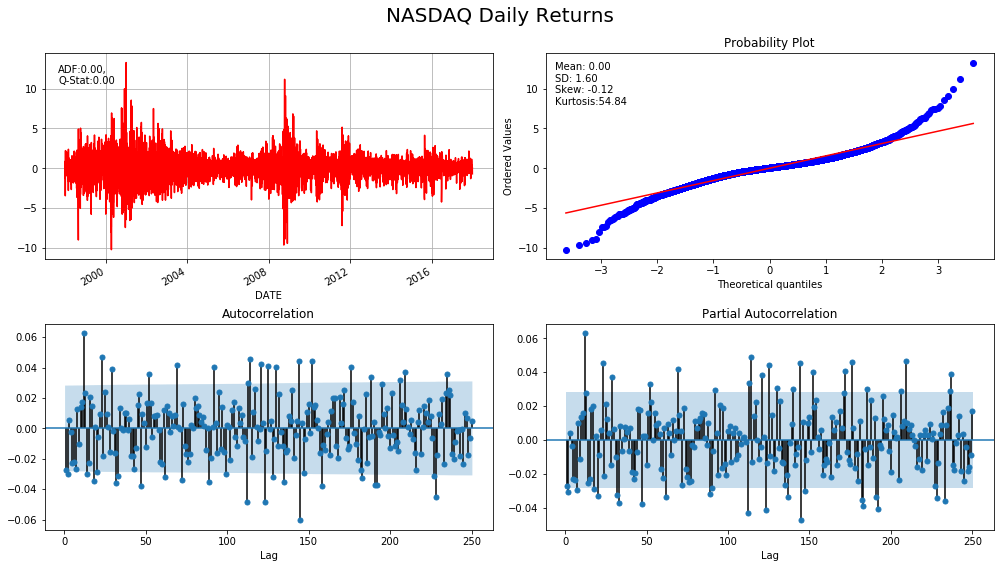

In [20]:
correlogram(log_nasdaq_returns_diff, lags=250, title='NASDAQ Daily Returns')

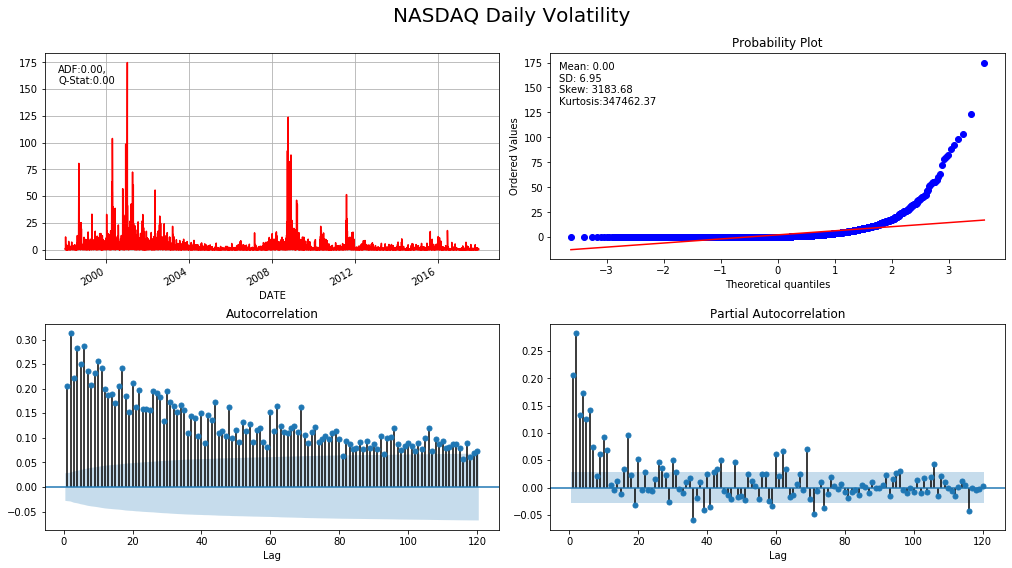

In [21]:
correlogram(log_nasdaq_returns_diff.sub(log_nasdaq_returns_diff.mean()).pow(2), lags=120, title='NASDAQ Daily Volatility')

## Order Selection: rolling out-of-sample forecasts

1. The objective is to estimate the GARCH model that captures the linear relationship of past volatilities. 

2. Rolling 10-year windows is the train data, p and q ranges from 1-4 to generate 1-step out-of-sample forecasts. 

3. Compare the RMSE of the predicted volatility of GARCG with the actual squared deviation of the return from its mean 

4. Winsorize the data to eliminate fat distributions

### Pilot code - Identify the orders to minimize RSE

In [231]:
nasdaq = web.DataReader('NASDAQCOM', 'fred', '2017-12-10', '2017-12-31').squeeze().dropna()

In [232]:
log_nasdaq= np.log(nasdaq)
log_nasdaq_diff=log_nasdaq.diff().dropna().mul(100)

In [233]:
log_nasdaq_diff

DATE
2017-12-12   -0.185770
2017-12-13    0.196242
2017-12-14   -0.280652
2017-12-15    1.160737
2017-12-18    0.835244
2017-12-19   -0.442881
2017-12-20   -0.041509
2017-12-21    0.063190
2017-12-22   -0.077557
2017-12-26   -0.341244
2017-12-27    0.044539
2017-12-28    0.155801
2017-12-29   -0.675209
Name: NASDAQCOM, dtype: float64

In [235]:
trainsize =5
data = log_nasdaq_diff.clip(lower=log_nasdaq_diff.quantile(.05),
                           upper=log_nasdaq_diff.quantile(.95))
T = len(data)
test_results = {}
for p in range(1, 5):
    for q in range(1, 5):
        print(f'{p} | {q}')
        result = []
        for s, t in enumerate(range(trainsize, T-1)):
            print("s",s)
            print("t",t)
            train_set = data.iloc[s: t]
            print("train",train_set)
            test_set = data.iloc[t+1]  # 1-step ahead forecast
            print("test",test_set)
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1,0]
            print("mean",mu)
            var = forecast.variance.iloc[-1,0]
            print("variance",var)
            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        test_results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
s 0
t 5
train DATE
2017-12-12   -0.185770
2017-12-13    0.196242
2017-12-14   -0.280652
2017-12-15    0.965441
2017-12-18    0.835244
Name: NASDAQCOM, dtype: float64
test -0.04150864595633408
mean 0.28421645587685196
variance 0.3237801832083537
s 1
t 6
train DATE
2017-12-13    0.196242
2017-12-14   -0.280652
2017-12-15    0.965441
2017-12-18    0.835244
2017-12-19   -0.442881
Name: NASDAQCOM, dtype: float64
test 0.0631897033301243
mean 0.2548356534489754
variance 0.4268488836529349
s 2
t 7
train DATE
2017-12-14   -0.280652
2017-12-15    0.965441
2017-12-18    0.835244
2017-12-19   -0.442881
2017-12-20   -0.041509
Name: NASDAQCOM, dtype: float64
test -0.07755656991257354
mean 0.19932516581253368
variance 0.271567140171367
s 3
t 8
train DATE
2017-12-15    0.965441
2017-12-18    0.835244
2017-12-19   -0.442881
2017-12-20   -0.041509
2017-12-21    0.063190
Name: NASDAQCOM, dtype: float64
test -0.3412444545402238
mean 0.02932643695054598
variance 0.0009689456061838944
s 4
t 9
train DA

mean 0.00303211134612537
variance 0.008626830247495679
s 5
t 10
train DATE
2017-12-19   -0.442881
2017-12-20   -0.041509
2017-12-21    0.063190
2017-12-22   -0.077557
2017-12-26   -0.341244
Name: NASDAQCOM, dtype: float64
test 0.15580117626559087
mean -0.12043713323091271
variance 0.0018296108169746673
s 6
t 11
train DATE
2017-12-20   -0.041509
2017-12-21    0.063190
2017-12-22   -0.077557
2017-12-26   -0.341244
2017-12-27    0.044539
Name: NASDAQCOM, dtype: float64
test -0.5358123224637978
mean -0.06997957876192439
variance 0.06820454812768835
2 | 3
s 0
t 5
train DATE
2017-12-12   -0.185770
2017-12-13    0.196242
2017-12-14   -0.280652
2017-12-15    0.965441
2017-12-18    0.835244
Name: NASDAQCOM, dtype: float64
test -0.04150864595633408
mean 0.283000859339222
variance 0.3220520362579204
s 1
t 6
train DATE
2017-12-13    0.196242
2017-12-14   -0.280652
2017-12-15    0.965441
2017-12-18    0.835244
2017-12-19   -0.442881
Name: NASDAQCOM, dtype: float64
test 0.0631897033301243
mean 0.254

mean -0.12040123901657049
variance 0.0018259637193632217
s 6
t 11
train DATE
2017-12-20   -0.041509
2017-12-21    0.063190
2017-12-22   -0.077557
2017-12-26   -0.341244
2017-12-27    0.044539
Name: NASDAQCOM, dtype: float64
test -0.5358123224637978
mean -0.06998665973511924
variance 0.06819660334157426
3 | 4
s 0
t 5
train DATE
2017-12-12   -0.185770
2017-12-13    0.196242
2017-12-14   -0.280652
2017-12-15    0.965441
2017-12-18    0.835244
Name: NASDAQCOM, dtype: float64
test -0.04150864595633408
mean 0.2829303109357771
variance 0.3221220981911134
s 1
t 6
train DATE
2017-12-13    0.196242
2017-12-14   -0.280652
2017-12-15    0.965441
2017-12-18    0.835244
2017-12-19   -0.442881
Name: NASDAQCOM, dtype: float64
test 0.0631897033301243
mean 0.2548382590848216
variance 0.4268427244470911
s 2
t 7
train DATE
2017-12-14   -0.280652
2017-12-15    0.965441
2017-12-18    0.835244
2017-12-19   -0.442881
2017-12-20   -0.041509
Name: NASDAQCOM, dtype: float64
test -0.07755656991257354
mean 0.28839

mean -0.06999027292329105
variance 0.06819367217539739


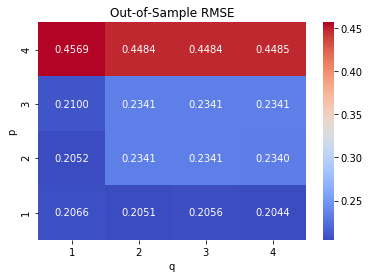

In [236]:
s = pd.Series(test_results)
s.index.names = ['p', 'q']
s = s.unstack().sort_index(ascending=False)
sns.heatmap(s, cmap='coolwarm', annot=True, fmt='.4f')
plt.title('Out-of-Sample RMSE');

#### Final_Code

In [22]:
log_nasdaq_returns_diff.shape

(4852,)

In [23]:
train_size = 10 * 252
final_data = log_nasdaq_returns_diff.clip(lower=log_nasdaq_returns_diff.quantile(.05),
                           upper=log_nasdaq_returns_diff.quantile(.95))
total = len(final_data)
test_results = {}
for p in range(1, 5):
    for q in range(1, 5):
        print(p,q)
        result = []
        for x1, x2 in enumerate(range(train_size, total-1)):
            train_set = final_data.iloc[x1: x2]
            test_set = final_data.iloc[x2+1]  # 1-step ahead forecast
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecast = model.forecast(horizon=1)
            mu = forecast.mean.iloc[-1,0]
            var = forecast.variance.iloc[-1,0]
            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        test_results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 1
1 2
1 3
1 4
2 1
2 2
2 3
2 4
3 1
3 2
3 3
3 4
4 1
4 2
4 3
4 4


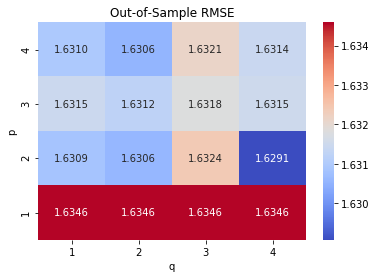

In [25]:
import seaborn as sns
series = pd.Series(test_results)
series.index.names = ['p', 'q']
series = s.unstack().sort_index(ascending=False)
sns.heatmap(s, cmap='coolwarm', annot=True, fmt='.4f')
plt.title('Out-of-Sample RMSE');

###  Estimate GARCH(2, 2) Model

In [30]:
gm = ConstantMean(log_nasdaq_returns_diff.clip(lower=log_nasdaq_returns_diff.quantile(.05),
                                      upper=log_nasdaq_returns_diff.quantile(.95)))
gm.volatility = GARCH(2,0,2)
gm.distribution = Normal()
model = gm.fit(update_freq=10)
print(model.summary())

Iteration:     10,   Func. Count:     95,   Neg. LLF: 7484.0554748785635
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7484.02292716963
            Iterations: 15
            Function evaluations: 136
            Gradient evaluations: 15
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              NASDAQCOM   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -7484.02
Distribution:                  Normal   AIC:                           14980.0
Method:            Maximum Likelihood   BIC:                           15019.0
                                        No. Observations:                 4852
Date:                Mon, Jun 29 2020   Df Residuals:                     4846
Time:                        09:17:33   Df Model:                            6
      

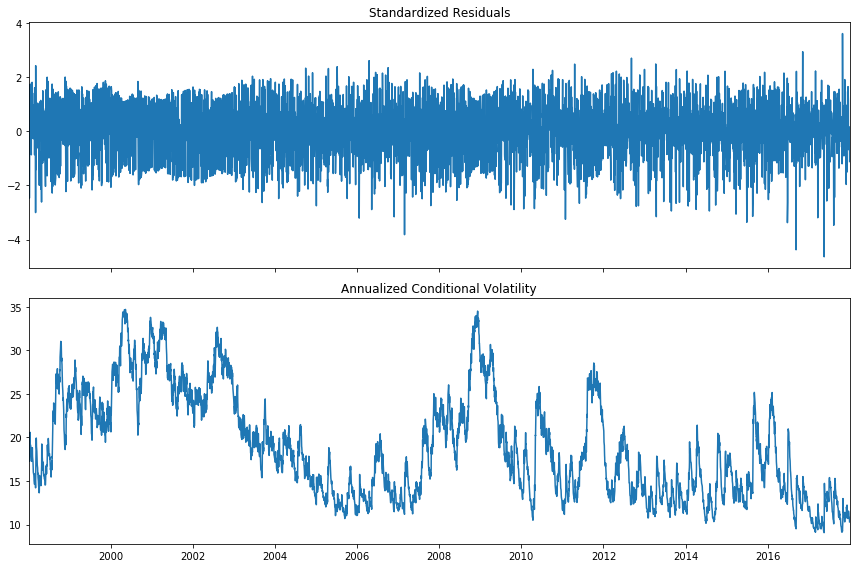

In [31]:
fig = model.plot(annualize='D')
fig.set_size_inches(12, 8)
fig.tight_layout();

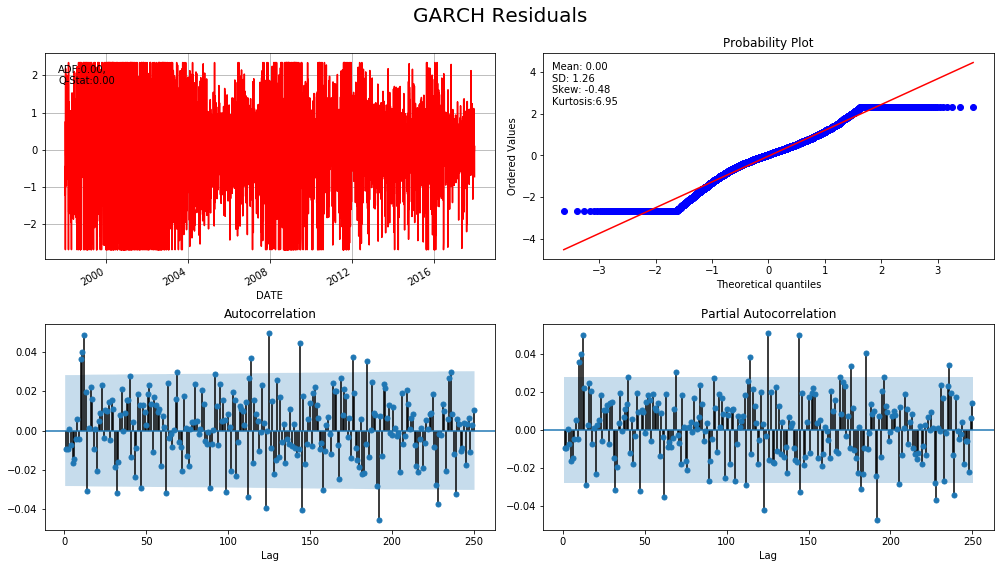

In [33]:
correlogram(model.resid.dropna(), lags=250, title='GARCH Residuals')

#### More on ARCH models :
    
https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html